In [1]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#pip install tensorflow

In [2]:
###
cut_off_dim = 6
###
def drawState(state):
    fig = plt.figure()
    X = np.linspace(-5, 5, 100)
    P = np.linspace(-5, 5, 100)
    Z = state.wigner(0, X, P)
    X, P = np.meshgrid(X, P)
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
    fig.set_size_inches(4.8, 5)
    ax.set_axis_off()

In [ ]:
#USING VARIABLES IN QUANTUM CIRCUIT

In [3]:
prog = sf.Program(2)
# we can create symbolic parameters one by one
alpha = prog.params("alpha") #Naming Prog Parameters

# or create multiple at the same time
theta_bs, phi_bs = prog.params("theta_bs", "phi_bs")

with prog.context as q:
    # States
    Coherent(alpha) | q[0]
    # Gates
    BSgate(theta_bs, phi_bs) | (q[0], q[1])
    # Measurements
    MeasureHomodyne(0.0) | q[0]

In [4]:
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cut_off_dim+1})

In [10]:
mapping = {"alpha": tf.Variable(1.5), "theta_bs": tf.constant(0.4), "phi_bs": tf.constant(0.0)}

result = eng.run(prog, args=mapping)

In [11]:
print(result.samples)

tf.Tensor([[2.2691226+0.j]], shape=(1, 1), dtype=complex64)


In [12]:
state = result.state
print("Density matrix element [0,0,1,2]:", state.dm()[0, 0, 1, 2])

Density matrix element [0,0,1,2]: tf.Tensor((0.18988127+0j), shape=(), dtype=complex64)


None

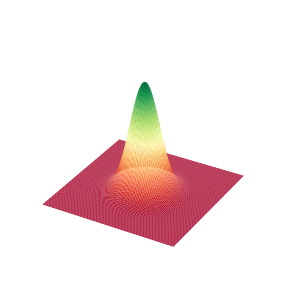

In [13]:
###
display(drawState(state))
###

In [ ]:
#USING TENSOR VARIABLES & CALCULATING GRADIENT IN QUANTUM CIRCUIT

In [14]:
eng.reset()
prog = sf.Program(1)

alpha = prog.params("alpha")

with prog.context as q:
    Dgate(alpha) | q

# Assign our TensorFlow variables, so that we can
# refer to them later when differentiating/training.
a = tf.Variable(0.43)

with tf.GradientTape() as tape:
    # Here, we map our quantum free parameter `alpha`
    # to our TensorFlow variable `a` and pass it to the engine.

    result = eng.run(prog, args={"alpha": a})
    state = result.state

    # Note that all processing, including state-based post-processing,
    # must be done within the gradient tape context!
    mean, var = state.mean_photon(0) #gradient of the mean is recorded
#looks at the gradient over a small change of variable

# test that the gradient of the mean photon number is correct

grad = tape.gradient(mean, [a])
print("Gradient:", grad)

Gradient: [<tf.Tensor: shape=(), dtype=float32, numpy=0.85999966>]


In [15]:
print("Exact gradient:", 2 * a)
print("Exact and TensorFlow gradient agree:", np.allclose(grad, 2 * a))

Exact gradient: tf.Tensor(0.86, shape=(), dtype=float32)
Exact and TensorFlow gradient agree: True


In [ ]:
#GETTING MEAN OF A CIRCUIT

In [16]:
eng.reset()
prog = sf.Program(2)

with prog.context as q:
    MeasureX | q[0]
    Dgate(sf.math.sin(q[0].par)) | q[1]

result = eng.run(prog)
print("Measured Homodyne sample from mode 0:", result.samples[0][0])

mean, var = result.state.mean_photon(0)
print("Mean photon number of mode 0:", mean)

mean, var = result.state.mean_photon(1)
print("Mean photon number of mode 1:", mean)

Measured Homodyne sample from mode 0: tf.Tensor((0.118901186+0j), shape=(), dtype=complex64)
Mean photon number of mode 0: tf.Tensor(0.0, shape=(), dtype=float32)
Mean photon number of mode 1: tf.Tensor(0.014070994, shape=(), dtype=float32)


In [ ]:
#VARIATIONAL SOLVER CIRCUIT

In [45]:
# initialize engine and program objects
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cut_off_dim + 1})
circuit = sf.Program(1)

tf_alpha = tf.Variable(-6.0)
tf_phi = tf.Variable(np.pi/2)

alpha, phi = circuit.params("alpha", "phi")

with circuit.context as q:
    Dgate(alpha, phi) | q[0] #displacement

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
steps = 1000

for step in range(steps):

    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        # execute the engine
        results = eng.run(circuit, args={"alpha": tf_alpha, "phi": tf_phi})
        # get the probability of fock state |1>
        prob = results.state.fock_prob([5])
        # negative sign to maximize prob
        loss = -prob

    gradients = tape.gradient(loss, [tf_alpha, tf_phi])
    opt.apply_gradients(zip(gradients, [tf_alpha, tf_phi]))
    print("Probability at step {}: {}".format(step, prob))
    ###
    #state = eng.run(circuit).state
    #display(drawState(state))
    ###
#BARREN PLATEUS - NO GRADIENT TO DO SIGNIFICANT LEARNING ON

Probability at step 0: 1.168772301163301e-10
Probability at step 1: 1.1692334600521548e-10
Probability at step 2: 1.1698846058560974e-10
Probability at step 3: 1.1706859093241206e-10
Probability at step 4: 1.1716089209912184e-10
Probability at step 5: 1.1726425386271444e-10
Probability at step 6: 1.1737756600016525e-10
Probability at step 7: 1.1750025952217413e-10
Probability at step 8: 1.1763114093898963e-10
Probability at step 9: 1.177703073951264e-10
Probability at step 10: 1.179171760234965e-10
Probability at step 11: 1.1807183009082678e-10
Probability at step 12: 1.1823360346330247e-10
Probability at step 13: 1.1840205205171372e-10
Probability at step 14: 1.1857714810048492e-10
Probability at step 15: 1.1875891936519167e-10
Probability at step 16: 1.1894746299034864e-10
Probability at step 17: 1.1914212671992885e-10
Probability at step 18: 1.1934297994287135e-10
Probability at step 19: 1.1954945366987602e-10
Probability at step 20: 1.19762186279182e-10
Probability at step 21: 1.19

Probability at step 183: 2.8823202158356764e-10
Probability at step 184: 2.9144106572509543e-10
Probability at step 185: 2.947262434105369e-10
Probability at step 186: 2.980880819958287e-10
Probability at step 187: 3.0153091135076693e-10
Probability at step 188: 3.050567576323715e-10
Probability at step 189: 3.0866911804317e-10
Probability at step 190: 3.1237148978568996e-10
Probability at step 191: 3.1616609330598067e-10
Probability at step 192: 3.2005656458444776e-10
Probability at step 193: 3.240453461117454e-10
Probability at step 194: 3.281381000252992e-10
Probability at step 195: 3.323372410601877e-10
Probability at step 196: 3.3664745990868994e-10
Probability at step 197: 3.410729754182995e-10
Probability at step 198: 3.4561850603687105e-10
Probability at step 199: 3.502872991667516e-10
Probability at step 200: 3.550859328793621e-10
Probability at step 201: 3.600180709106837e-10
Probability at step 202: 3.650907631769229e-10
Probability at step 203: 3.703098383489589e-10
Probabi

Probability at step 363: 0.17536288499832153
Probability at step 364: 0.17539411783218384
Probability at step 365: 0.1754368245601654
Probability at step 366: 0.17546406388282776
Probability at step 367: 0.1754639446735382
Probability at step 368: 0.17544403672218323
Probability at step 369: 0.17542317509651184
Probability at step 370: 0.17541702091693878
Probability at step 371: 0.1754285842180252
Probability at step 372: 0.17544862627983093
Probability at step 373: 0.1754639893770218
Probability at step 374: 0.17546683549880981
Probability at step 375: 0.17545881867408752
Probability at step 376: 0.17544817924499512
Probability at step 377: 0.17544351518154144
Probability at step 378: 0.17544753849506378
Probability at step 379: 0.17545679211616516
Probability at step 380: 0.1754649132490158
Probability at step 381: 0.1754673272371292
Probability at step 382: 0.17546409368515015
Probability at step 383: 0.17545899748802185
Probability at step 384: 0.17545616626739502
Probability at s

Probability at step 554: 0.175467386841774
Probability at step 555: 0.17546740174293518
Probability at step 556: 0.1754673570394516
Probability at step 557: 0.1754673570394516
Probability at step 558: 0.1754673570394516
Probability at step 559: 0.1754673570394516
Probability at step 560: 0.1754673570394516
Probability at step 561: 0.1754673570394516
Probability at step 562: 0.1754673570394516
Probability at step 563: 0.17546740174293518
Probability at step 564: 0.17546740174293518
Probability at step 565: 0.17546740174293518
Probability at step 566: 0.17546740174293518
Probability at step 567: 0.17546740174293518
Probability at step 568: 0.17546740174293518
Probability at step 569: 0.1754673570394516
Probability at step 570: 0.1754673570394516
Probability at step 571: 0.1754673570394516
Probability at step 572: 0.1754673570394516
Probability at step 573: 0.1754673570394516
Probability at step 574: 0.1754673570394516
Probability at step 575: 0.1754673570394516
Probability at step 576: 0

Probability at step 750: 0.1754673570394516
Probability at step 751: 0.1754673570394516
Probability at step 752: 0.1754673570394516
Probability at step 753: 0.1754673570394516
Probability at step 754: 0.1754673570394516
Probability at step 755: 0.1754673570394516
Probability at step 756: 0.1754673570394516
Probability at step 757: 0.1754673570394516
Probability at step 758: 0.1754673570394516
Probability at step 759: 0.1754673570394516
Probability at step 760: 0.1754673570394516
Probability at step 761: 0.1754673570394516
Probability at step 762: 0.1754673570394516
Probability at step 763: 0.1754673570394516
Probability at step 764: 0.1754673570394516
Probability at step 765: 0.1754673570394516
Probability at step 766: 0.1754673570394516
Probability at step 767: 0.1754673570394516
Probability at step 768: 0.1754673570394516
Probability at step 769: 0.1754673570394516
Probability at step 770: 0.1754673570394516
Probability at step 771: 0.1754673570394516
Probability at step 772: 0.17546

Probability at step 946: 0.1754673570394516
Probability at step 947: 0.1754673570394516
Probability at step 948: 0.1754673570394516
Probability at step 949: 0.1754673570394516
Probability at step 950: 0.1754673570394516
Probability at step 951: 0.1754673570394516
Probability at step 952: 0.1754673570394516
Probability at step 953: 0.1754673570394516
Probability at step 954: 0.1754673570394516
Probability at step 955: 0.1754673570394516
Probability at step 956: 0.1754673570394516
Probability at step 957: 0.1754673570394516
Probability at step 958: 0.1754673570394516
Probability at step 959: 0.1754673570394516
Probability at step 960: 0.1754673570394516
Probability at step 961: 0.1754673570394516
Probability at step 962: 0.1754673570394516
Probability at step 963: 0.1754673570394516
Probability at step 964: 0.1754673570394516
Probability at step 965: 0.1754673570394516
Probability at step 966: 0.1754673570394516
Probability at step 967: 0.1754673570394516
Probability at step 968: 0.17546

<tf.Variable 'Displacement/Variable:0' shape=() dtype=float32, numpy=-2.236068>
<tf.Variable 'Displacement/Variable:0' shape=() dtype=float32, numpy=1.5707964>
tf.Tensor(0.0067379456, shape=(), dtype=float32)
tf.Tensor(0.033689726, shape=(), dtype=float32)
tf.Tensor(0.08422432, shape=(), dtype=float32)
tf.Tensor(0.14037389, shape=(), dtype=float32)
tf.Tensor(0.17546736, shape=(), dtype=float32)
tf.Tensor(0.17546736, shape=(), dtype=float32)


None

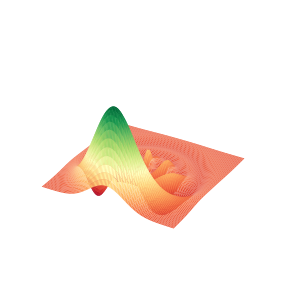

In [46]:
print(tf_alpha)
print(tf_phi)
# get the probability of fock state |i>
for i in range(cut_off_dim):
    prob = results.state.fock_prob([i])
    print(prob)
state = results.state
display(drawState(state))